## SAS Tip Tuesday: ODS Output With SASPy
*03/04/2025*

- *Stu Sztukowski*
- *https://linkedin.com/in/StatsGuy* | *https://github.com/stu-code*

***

ODS Output is one of SAS's most important features. From HTML to PDF to PowerPoint, you can create beautiful graphs to an insane number of destinations with barely any code. One of the best parts about SAS are the ODS graphics that are automatically produced with statistical output. You don't need to think too hard about what statistical tests, graphs, or measures you need: SAS just does it for you. It's incredibly powerful, and SASPy fully supports it. Let's take a look at some quick examples.

In [1]:
import saspy
from IPython.display import HTML

## Start a SAS session

You can configure the connection types you want within ~./config/saspy/sascfg_personal.py. 

We'll start a local connection to SAS installed on a local Windows machine, but you can easily connect to SAS Viya, SAS Grid, SAS Mainframe, or a remote SAS server. 

For more information on how to change how you connect to SAS, see:
https://sassoftware.github.io/saspy/getting-started.html#start-a-sas-session

In [2]:
sas = saspy.SASsession(cfgname='winlocal')

SAS Connection established. Subprocess id is 1112



## Read Data Directly

Now that we have started a SAS session, we can read  data directly with sas.read_csv, and save it as a table
to the WORK library as "insurance." We'll also read in a SAS dataset that already exists in sashelp: sashelp.air

In [3]:
url = 'https://github.com/stu-code/sas-tips/raw/refs/heads/main/data/insurance.csv'
insurance = sas.read_csv(url, table='insurance')
airline   = sas.sasdata('air', 'sashelp')

In [4]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


# Make some graphs

SASPy has built-in methods to automatically generate a number of graphs:
| Graph Type | Method |
|:-----------|:------|
| Bar chart  |data.bar()    |
| Heatmap    |data.heatmap()|
| Histogram  |data.hist()   |
| Scatterplot|data.scatter()|
| Series     |data.series()|


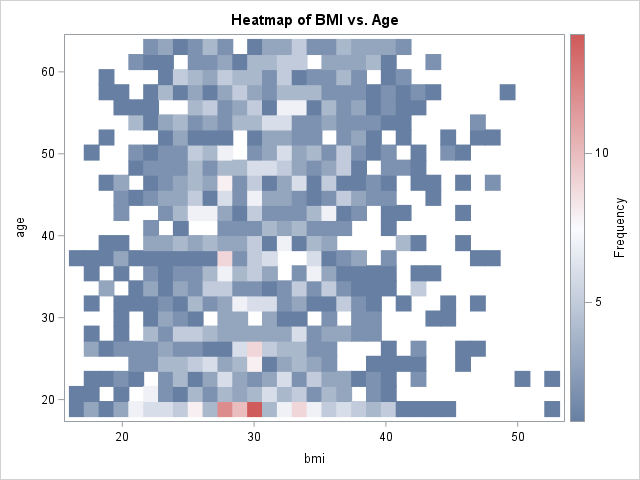

In [5]:
insurance.heatmap(x='bmi', y='age', title='Heatmap of BMI vs. Age')


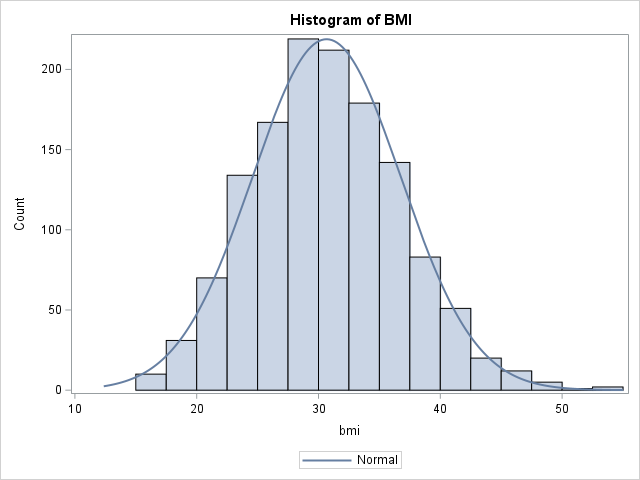

In [6]:
insurance.hist('BMI', title='Histogram of BMI')


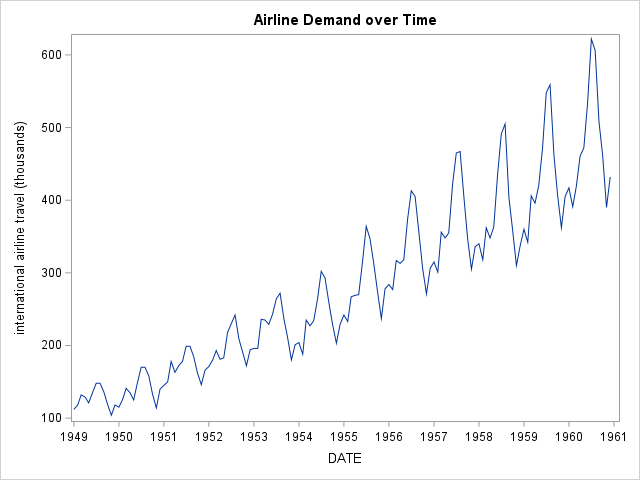

In [7]:
airline.series(x='Date', y='Air', title='Airline Demand over Time')

# Customize it!

But you're not limited to these methods alone. You can run PROC SGPLOT directly with ```sas.submit()```, get HTML results, and display them with the HTML function. That's the cool thing about ODS: we're outputting standard HTML. Anything can render it.


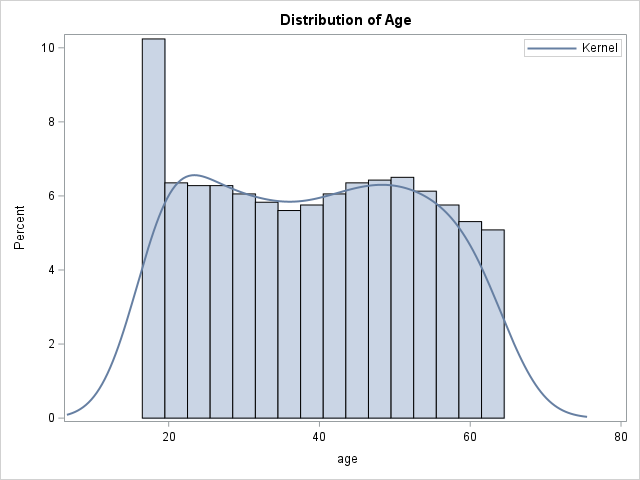

In [8]:
res = sas.submit(results='HTML', code=
'''
    title "Distribution of Age";

    proc sgplot data=insurance;
        histogram age;
        density age / type=kernel;
        keylegend / location=inside position=topright;
    run;
'''
)

HTML(res['LST'])

# ODS Output From Statistics

SAS automatically creates tons of diagnostic graphs for you for many different procedures. This saves time and allows you to assess and adjust your model faster. You don't need to worry about creating these graphs: SAS does it all for you. 

You can view all the graphs and tables produced by a procedure with the ```model.ALL()``` method.

In [9]:
stat = sas.sasstat()
ets  = sas.sasets()

,Class,Levels,Values
0,region,4.0,northeast northwest southeast southwest
1,sex,2.0,female male
2,smoker,2.0,no yes



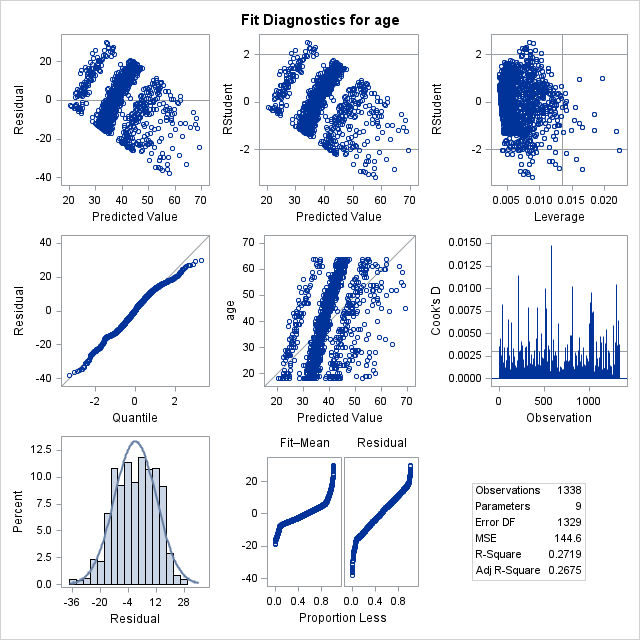

,RSquare,CV,RootMSE,DepMean
0,0.271852,30.670733,12.025082,39.207025


,HypothesisType,Source,DF,SS,MS,FValue,ProbF
0,1.0,bmi,1.0,3151.363124,3151.363124,21.793267,3.343857e-06
1,1.0,charges,1.0,21131.055640,21131.055640,146.131920,5.413314e-32
2,1.0,children,1.0,130.381298,130.381298,0.901653,3.425116e-01
3,1.0,region,3.0,630.758801,210.252934,1.454005,2.254519e-01
4,1.0,sex,1.0,421.692562,421.692562,2.916217,8.792678e-02
5,1.0,smoker,1.0,46283.546451,46283.546451,320.074095,2.636353e-64


,HypothesisType,Source,DF,SS,MS,FValue,ProbF
0,3.0,bmi,1.0,743.972333,743.972333,5.144944,2.347403e-02
1,3.0,charges,1.0,67382.452512,67382.452512,465.983684,7.783217e-89
2,3.0,children,1.0,31.934941,31.934941,0.220846,6.384730e-01
3,3.0,region,3.0,134.124305,44.708102,0.309179,8.187718e-01
4,3.0,sex,1.0,49.094553,49.094553,0.339514,5.602089e-01
5,3.0,smoker,1.0,46283.546451,46283.546451,320.074095,2.636353e-64


,Label,N,NObsUsed,NObsRead,SumFreqsUsed,SumFreqsRead,Label1,nvalue1,DependentVariables
0,Number of Observations Read,1338.0,1338.0,1338.0,1338.0,1338.0,Number of Observations Read,1338.0,age
1,Number of Observations Used,1338.0,1338.0,1338.0,1338.0,1338.0,Number of Observations Used,1338.0,age


,Source,DF,SS,MS,FValue,ProbF
0,Model,8.0,71748.797876,8968.599735,62.022396,2.794760e-86
1,Error,1329.0,192176.856085,144.602601,NaN,NaN
2,Corrected Total,1337.0,263925.653961,NaN,NaN,NaN



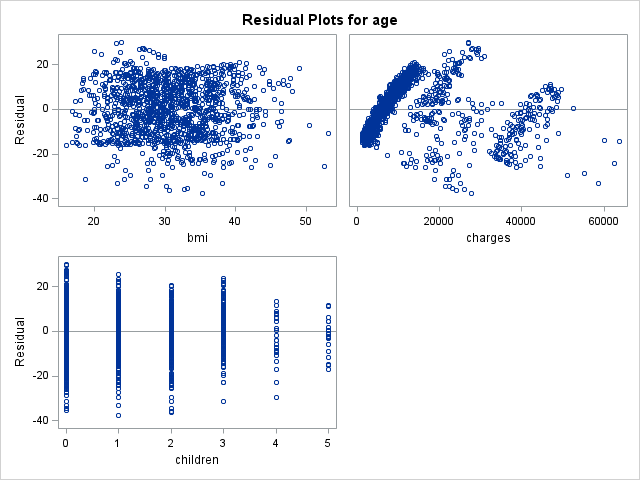

In [10]:
reg = stat.glm(
    data=insurance,
    cls=['region', 'sex', 'smoker'],
    model='age = bmi charges children region sex smoker',
    stmtpassthrough='output out=reg_preds p=p_age'
)

reg.ALL()

Or, you can specify a specific output by looking at which plots are available in the results. For example, the following tables and graphs are available from an ARIMA model:

```
['CHISQAUTO1_ESTIMATE1', 'CHISQAUTO1_IDENTIFY1', 'CORRB', 'DESCSTATS', 'FITSTATISTICS', 'FORECASTS', 'FORECASTSONLYPLOT', 'FORECASTSPLOT', 'MODELDESCRIPTION', 'PARAMETERESTIMATES', 'RESIDUALCORRPANEL', 'RESIDUALNORMALITYPANEL', 'RESIDUALPLOT', 'SERIESCORRPANEL', 'LOG']
```

In [11]:
arima = ets.arima(
    data=airline,
    identify='var=air(1 12)',
    estimate='q=(1)(12) noint method=ml',
    forecast='lead=12'
)


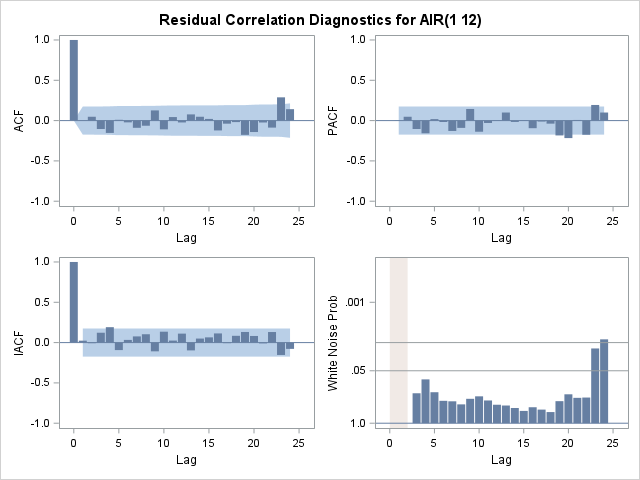

In [12]:
arima.RESIDUALCORRPANEL

In [13]:
arima.PARAMETERESTIMATES

,Parameter,Estimate,StdErr,tValue,Probt,Lag
0,"MA1,1",0.308759,0.084300,3.662626,0.000250,1.0
1,"MA2,1",0.107376,0.101889,1.053858,0.291948,12.0



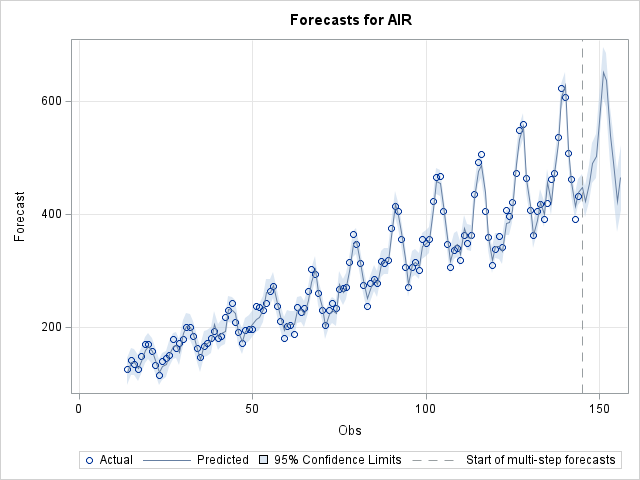

In [14]:
arima.FORECASTSPLOT